### Step 1: Data Preparation

In [1]:
import os
import json
import re

# ========== Path Config ==========
EXTRACT_DIR = '../data/twitter15/twitter15'
TREE_DIR = os.path.join(EXTRACT_DIR, 'tree')
OUTPUT_PATH = os.path.join(EXTRACT_DIR, 'twitter15_chain.jsonl')

In [2]:
# ========== Load label.txt ==========
def load_labels(path):
    """Load labels from label.txt in format: label:tweet_id"""
    label_dict = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(":")
            if len(parts) == 2:
                label, eid = parts
                label_dict[eid.strip()] = label.strip().lower()
    return label_dict

# ========== Load source_tweets.txt ==========
def load_texts(path):
    """Load tweet_id and text from source_tweets.txt"""
    text_dict = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                eid, text = parts
                text_dict[eid.strip()] = text.strip()
    return text_dict

# ========== Parse tree file ==========
def parse_tree_file(tree_path):
    """Parse a single tree file into (child_tid, parent_tid) edges"""
    edges = []
    with open(tree_path, 'r') as f:
        for line in f:
            if '->' not in line:
                continue
            src, tgt = line.strip().split('->')
            src = eval(src.strip())  # e.g., ['ROOT'] or [user_id, tweet_id, time]
            tgt = eval(tgt.strip())
            parent_tid = None if src[0] == 'ROOT' else src[1]
            child_tid = tgt[1]
            edges.append((child_tid, parent_tid))
    return edges

# ========== Build single event ==========
def build_event_chain(eid, tree_dir, eid2text, eid2label):
    tree_path = os.path.join(tree_dir, f"{eid}.txt")
    edge_list = parse_tree_file(tree_path)

    chain = []
    for child_tid, parent_tid in edge_list:
        text = eid2text.get(child_tid, "")
        chain.append({
            'tweet_id': child_tid,
            'text': text,
            'parent': parent_tid or 'ROOT'
        })

    return {
        'event_id': eid,
        'label': eid2label[eid],
        'chain': chain
    }

# ========== Run full pipeline ==========
def process_all_events(label_path, text_path, tree_dir, output_path):
    # Load label and text dictionaries
    eid2label = load_labels(label_path)
    eid2text = load_texts(text_path)

    print(" Sample label:")
    print(list(eid2label.items())[:3])
    print("\n Sample text:")
    print(list(eid2text.items())[:3])

    # Build event chains
    all_events = []
    for eid in eid2label:
        if eid in eid2text:
            event = build_event_chain(eid, tree_dir, eid2text, eid2label)
            all_events.append(event)

    # Print one sample event chain
    print("\n Sample processed event:")
    print(f"Event ID: {all_events[0]['event_id']}")
    print(f"Label: {all_events[0]['label']}")
    print(f"Chain Length: {len(all_events[0]['chain'])} nodes")

    # Save to jsonl
    with open(output_path, 'w') as f:
        for event in all_events:
            f.write(json.dumps(event) + '\n')

    # Only show first 5 nodes in chain
    print("\nFirst 5 nodes in chain:")
    for node in all_events[0]['chain'][:5]:
        print(f"  Tweet ID: {node['tweet_id']} | Parent: {node['parent']} | Text snippet: {node['text'][:30]}...")
    
    print(f"\n Saved {len(all_events)} propagation chains to {output_path}")

# ========== Execute ==========
if __name__ == "__main__" or True:  # for notebook
    process_all_events(
        label_path=os.path.join(EXTRACT_DIR, 'label.txt'),
        text_path=os.path.join(EXTRACT_DIR, 'source_tweets.txt'),
        tree_dir=TREE_DIR,
        output_path=OUTPUT_PATH
    )

 Sample label:
[('731166399389962242', 'unverified'), ('714598641827246081', 'unverified'), ('691809004356501505', 'non-rumor')]

 Sample text:
[('731166399389962242', '🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL'), ('714598641827246081', 'an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom'), ('691809004356501505', '"america is a nation of second chances" —@potus on new reforms to solitary confinement: URL URL')]

 Sample processed event:
Event ID: 731166399389962242
Label: unverified
Chain Length: 148 nodes

First 5 nodes in chain:
  Tweet ID: 731166399389962242 | Parent: ROOT | Text snippet: 🔥ca kkk grand wizard 🔥 endorse...
  Tweet ID: 731168205788471297 | Parent: 731166399389962242 | Text snippet: ...
  Tweet ID: 731166399389962242 | Parent: 731166399389962242 | Text snippet: 🔥ca kkk grand wizard 🔥 endorse...
  Tweet ID: 731166399389962242 | Parent: 731166399389962242 | Text snippet: 🔥ca kkk grand wizard 🔥 e

### Step 2: Feature Construction for Mamba

In [3]:
# 2.1 Load the processed propagation chain data
import json

# Load processed propagation chains
CHAIN_PATH = '../data/twitter15/twitter15/twitter15_chain.jsonl'

all_events = []
with open(CHAIN_PATH, 'r') as f:
    for line in f:
        all_events.append(json.loads(line))

print(f"Loaded {len(all_events)} events.")

# 2.1b Build tweet_id -> relative_time dictionary from tree files
def build_tweet_time_dict(tree_dir):
    eid2time = {}  # {tweet_id: relative_time}

    for fname in os.listdir(tree_dir):
        if not fname.endswith('.txt'):
            continue
        
        tree_path = os.path.join(tree_dir, fname)

        with open(tree_path, 'r') as f:
            for line in f:
                if '->' not in line:
                    continue
                src, tgt = line.strip().split('->')
                src_info = eval(src.strip())
                tgt_info = eval(tgt.strip())

                target_tid = tgt_info[1]
                target_time = float(tgt_info[2])

                eid2time[target_tid] = target_time

    return eid2time

eid2time = build_tweet_time_dict(TREE_DIR)

print(f"Built time dictionary with {len(eid2time)} entries.")

print(f"Sample event ID: {all_events[0]['event_id']}, chain length: {len(all_events[0]['chain'])}")


Loaded 1490 events.
Built time dictionary with 53641 entries.
Sample event ID: 731166399389962242, chain length: 148


In [17]:
# 2.2 Text feature: Encode tweet text with BERT
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.cuda()

def encode_texts_with_bert(texts, tokenizer, model):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for text in texts:
            if not text.strip():
                embeddings.append(torch.zeros(768))
                continue
            inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
            inputs = {k: v.cuda() for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embedding.squeeze(0).cpu())
    return torch.stack(embeddings)

# 2.3 Time feature (Real version)
def get_relative_time_features(chain, eid2time):
    relative_times = []

    for node in chain:
        tid = node['tweet_id']
        t = eid2time.get(tid, 0.0)  # fallback to 0 if not found
        delta_t_log = torch.log1p(torch.tensor(t, dtype=torch.float32))  # log(Δt + 1)
        relative_times.append(delta_t_log.unsqueeze(0))

    return torch.cat(relative_times, dim=0).unsqueeze(1)  # (num_nodes, 1)

# 2.4 user features (simulating user embedding)
import torch.nn as nn

user_vocab_size = 50000
user_embedding_dim = 64
user_embedding_layer = nn.Embedding(user_vocab_size, user_embedding_dim)

def get_user_embeddings(chain):
    user_ids = [int(node['tweet_id']) % user_vocab_size for node in chain]
    user_ids = torch.tensor(user_ids, dtype=torch.long)
    user_embeds = user_embedding_layer(user_ids)
    return user_embeds

# 2.5 Concatenate all features into the final node vector

def build_node_features(chain, tokenizer, bert_model, user_embedding_layer, eid2time):
    texts = [node['text'] for node in chain]
    text_embeddings = encode_texts_with_bert(texts, tokenizer, bert_model)  # (num_nodes, 768)
    time_features = get_relative_time_features(chain, eid2time)             # (num_nodes, 1)
    user_embeddings = get_user_embeddings(chain)                            # (num_nodes, 64)

    return torch.cat([text_embeddings, time_features, user_embeddings], dim=-1)

In [18]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

features_list = []
labels = []

label_encoder = LabelEncoder()

for event in tqdm(all_events):
    node_features = build_node_features(event['chain'], tokenizer, bert_model, user_embedding_layer, eid2time)
    features_list.append(node_features)
    labels.append(event['label'])

label_ids = label_encoder.fit_transform(labels)

# save
torch.save(features_list, "../processed/twitter15_node_features.pt")
torch.save(label_ids, "../processed/twitter15_labels.pt")
torch.save(label_encoder, "../processed/twitter15_label_encoder.pkl")

100%|██████████| 1490/1490 [37:08<00:00,  1.50s/it] 


 ### Step 3: Propagation Graph Construction 

In [19]:
import torch
import json

# Load features and labels
node_features_list = torch.load("../processed/twitter15_node_features.pt")
label_ids = torch.load("../processed/twitter15_labels.pt")

# Load propagation chains
CHAIN_PATH = '../data/twitter15/twitter15/twitter15_chain.jsonl'
all_events = []
with open(CHAIN_PATH, 'r') as f:
    for line in f:
        all_events.append(json.loads(line))

print(f"Loaded {len(all_events)} events.")

# Build edge_index
def build_edge_index(chain):
    node_id_map = {node['tweet_id']: idx for idx, node in enumerate(chain)}
    edges = []
    for node in chain:
        child_idx = node_id_map[node['tweet_id']]
        if node['parent'] != 'ROOT':
            parent_idx = node_id_map.get(node['parent'], None)
            if parent_idx is not None:
                edges.append((parent_idx, child_idx))
    if len(edges) == 0:
        edges.append((0, 0))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# Assemble graphs
graph_data_list = []

for i, event in enumerate(all_events):
    node_features = node_features_list[i]
    label = label_ids[i]
    edge_index = build_edge_index(event['chain'])

    graph = {
        'x': node_features,
        'edge_index': edge_index,
        'y': label
    }
    graph_data_list.append(graph)

# Save
torch.save(graph_data_list, "../processed/twitter15_graph_data.pt")
print(" Saved graph data to ../processed/twitter15_graph_data.pt")

/var/tmp/ipykernel_25070/2133137723.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  node_features_list = torch.load("../processed/twitter15_node_features.pt")
/var/tmp/i

Loaded 1490 events.
 Saved graph data to ../processed/twitter15_graph_data.pt


### Step 4: Data exploration

In [1]:
from sklearn.preprocessing import LabelEncoder
import pickle

label_encoder = LabelEncoder()
label_encoder.fit(['false', 'non-rumor', 'true', 'unverified'])

with open("../processed/twitter15_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

print(" Successfully created and saved a new label_encoder!")
print("Classes:", label_encoder.classes_)

 Successfully created and saved a new label_encoder!
Classes: ['false' 'non-rumor' 'true' 'unverified']


In [2]:
import torch
import pickle
import os

# ========== Path Config ==========
DATA_DIR = "../processed/"
FEATURES_FILE = os.path.join(DATA_DIR, "twitter15_node_features.pt")
LABELS_FILE = os.path.join(DATA_DIR, "twitter15_labels.pt")
LABEL_ENCODER_FILE = os.path.join(DATA_DIR, "twitter15_label_encoder.pkl")
GRAPH_FILE = os.path.join(DATA_DIR, "twitter15_graph_data.pt")

# ========== Load Processed Data ==========
node_features_list = torch.load(FEATURES_FILE, weights_only=False)    # list of [num_nodes, 833] tensors
label_ids = torch.load(LABELS_FILE, weights_only=False)                # tensor of labels

with open(LABEL_ENCODER_FILE, 'rb') as f:
    label_encoder = pickle.load(f)                                     # label encoder

graph_data_list = torch.load(GRAPH_FILE, weights_only=False)           # list of PyG Data objects

print(f"Loaded {len(node_features_list)} node feature sequences.")
print(f"Loaded {len(label_ids)} labels.")
print(f"Loaded {len(graph_data_list)} propagation graphs.")
print(f"Label classes: {label_encoder.classes_}")
# 2. fix NaN
for i in range(len(node_features_list)):
    node_features_list[i] = torch.nan_to_num(node_features_list[i], nan=0.0)

print(" All NaN replaced by 0.0 in node features!")

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Loaded 1490 node feature sequences.
Loaded 1490 labels.
Loaded 1490 propagation graphs.
Label classes: ['false' 'non-rumor' 'true' 'unverified']
 All NaN replaced by 0.0 in node features!


### 4.1 探索 node_features_list

数据结构

总共：768 + 1 + 64 = 833维

文本内容 (BERT embedding)	768维	把节点文本用BERT编码，抽象出语义向量

时间特征 (time delta)	1维	节点与源节点之间的时间差（通常标准化过）

用户特征 (user id embedding)	64维	把用户ID编码成一个64维向量

节点ID | 用户 | 内容 | 角色

0 | A | "某地爆炸了！！"（源推文） | 源头

1 | B | 转发A的推文 | 第一代传播

2 | C | 转发A的推文 | 第一代传播

3 | D | 转发B的转发 | 第二代传播

In [3]:
import torch
import numpy as np

# 合并所有节点特征
all_node_features = torch.cat(node_features_list, dim=0)  # Shape [total_nodes, 833]

print(f"Total number of nodes: {all_node_features.shape[0]}")
print(f"Feature dimension per node: {all_node_features.shape[1]}")

# 计算特征均值和标准差
feature_means = torch.mean(all_node_features, dim=0)
feature_stds = torch.std(all_node_features, dim=0)

print("Feature Means (first 10 dims):", feature_means[:10])
print("Feature Stds (first 10 dims):", feature_stds[:10])

# 每个特征的最大值、最小值
feature_maxs = torch.max(all_node_features, dim=0).values
feature_mins = torch.min(all_node_features, dim=0).values

print("Feature Maxs (first 10 dims):", feature_maxs[:10])
print("Feature Mins (first 10 dims):", feature_mins[:10])

# 检查有没有方差接近0的特征
near_zero_var_count = torch.sum(feature_stds < 1e-6).item()
print(f"Number of near-zero variance features: {near_zero_var_count}")

Total number of nodes: 607289
Feature dimension per node: 833
Feature Means (first 10 dims): tensor([-0.2539, -0.1131, -0.0734, -0.2146, -0.3849, -0.1318,  0.3193,  0.4715,
        -0.1608, -0.1220], grad_fn=<SliceBackward0>)
Feature Stds (first 10 dims): tensor([0.2741, 0.1853, 0.2084, 0.2120, 0.2464, 0.2648, 0.2313, 0.2426, 0.2207,
        0.1908], grad_fn=<SliceBackward0>)
Feature Maxs (first 10 dims): tensor([0.4496, 0.5514, 0.8548, 0.6123, 0.3995, 0.8196, 1.3804, 1.2314, 0.6244,
        0.6327], grad_fn=<SliceBackward0>)
Feature Mins (first 10 dims): tensor([-1.3035, -0.8222, -0.8862, -1.1078, -1.3406, -0.9820, -0.2369, -0.1708,
        -0.9590, -0.8842], grad_fn=<SliceBackward0>)
Number of near-zero variance features: 0


Number of events: 1490
Nodes per event - Min: 56, Max: 3009, Mean: 407.58


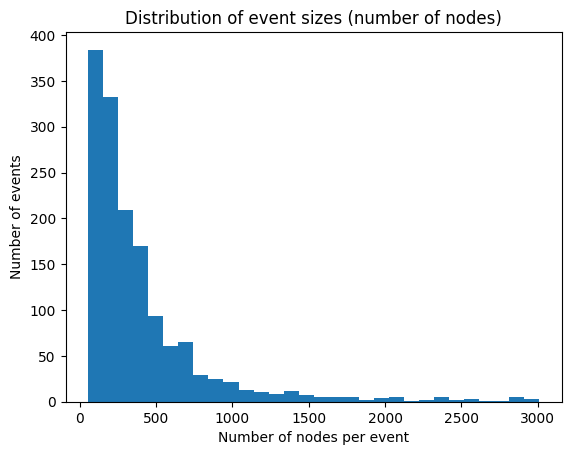

In [7]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 1. 数据基本情况
num_events = len(node_features_list)
print(f"Number of events: {num_events}")

# 每条事件的节点数
num_nodes_per_event = [features.shape[0] for features in node_features_list]
print(f"Nodes per event - Min: {np.min(num_nodes_per_event)}, Max: {np.max(num_nodes_per_event)}, Mean: {np.mean(num_nodes_per_event):.2f}")

# 画节点数分布直方图
plt.hist(num_nodes_per_event, bins=30)
plt.xlabel("Number of nodes per event")
plt.ylabel("Number of events")
plt.title("Distribution of event sizes (number of nodes)")
plt.show()

### 4.2 twitter15_labels.pt

In [12]:
print(label_ids[:10])  # 看前10条事件的标签ID
print(label_encoder.inverse_transform(label_ids[:10].tolist()))  # 看前10条对应的类别名

[3 3 1 1 2 1 3 2 3 0]
['unverified' 'unverified' 'non-rumor' 'non-rumor' 'true' 'non-rumor'
 'unverified' 'true' 'unverified' 'false']


原本是list，训练时需要转换为tensor

In [8]:
import torch

# 确保 label_ids 是Tensor
label_ids = torch.as_tensor(label_ids)

# 打印基本信息
print(f"Total number of events: {label_ids.shape[0]}")

# 统计每类标签数量
unique_labels, counts = torch.unique(label_ids, return_counts=True)

# 用LabelEncoder还原成文字
for label_idx, count in zip(unique_labels.tolist(), counts.tolist()):
    label_name = label_encoder.inverse_transform([label_idx])[0]
    print(f"Label '{label_name}': {count} events")

Total number of events: 1490
Label 'false': 370 events
Label 'non-rumor': 374 events
Label 'true': 372 events
Label 'unverified': 374 events


### 4.3 探索twitter15_label_encoder.pkl

In [13]:
print("LabelEncoder classes:", label_encoder.classes_)

LabelEncoder classes: ['false' 'non-rumor' 'true' 'unverified']


In [14]:
#sample usage

# 字符串转数字
print(label_encoder.transform(['true', 'false', 'unverified']))
# ➔ 输出 tensor([2, 0, 3])

# 数字转字符串
print(label_encoder.inverse_transform([2, 0, 3]))
# ➔ 输出 ['true', 'false', 'unverified']

[2 0 3]
['true' 'false' 'unverified']


### 4.4 探索 twitter15_graph_data.pt

In [32]:
import torch
# 打印总数量
print(f"Total number of events: {len(graph_data_list)}")

# 打印第一个事件的基本结构
sample_graph = graph_data_list[14]

print("Sample Graph Keys:", sample_graph.keys())
print(f"Sample Graph - number of nodes: {sample_graph['x'].shape[0]}")
print(f"Sample Graph - edge_index shape: {sample_graph['edge_index'].shape}")
print(f"Sample Graph - label (y): {sample_graph['y'].item()}")

# 打印前5条传播边
print("First 5 edges (parent ➔ child):")
print(sample_graph['edge_index'][:, :5])

# 正确统计所有事件的节点数、边数
num_nodes_list = [g['x'].shape[0] for g in graph_data_list]
num_edges_list = [g['edge_index'].shape[1] for g in graph_data_list]

print(f"Nodes per event - Min: {min(num_nodes_list)}, Max: {max(num_nodes_list)}, Mean: {sum(num_nodes_list)/len(num_nodes_list):.2f}")
print(f"Edges per event - Min: {min(num_edges_list)}, Max: {max(num_edges_list)}, Mean: {sum(num_edges_list)/len(num_edges_list):.2f}")

Total number of events: 1490
Sample Graph Keys: dict_keys(['x', 'edge_index', 'y'])
Sample Graph - number of nodes: 758
Sample Graph - edge_index shape: torch.Size([2, 15])
Sample Graph - label (y): 3
First 5 edges (parent ➔ child):
tensor([[757, 757, 757, 757, 757],
        [150, 157, 198, 261, 755]])
Nodes per event - Min: 56, Max: 3009, Mean: 407.58
Edges per event - Min: 0, Max: 1872, Mean: 42.99


In [33]:
print(sample_graph)

{'x': tensor([[-0.4275, -0.2643, -0.2163,  ...,  1.0586,  0.5130,  0.3346],
        [-0.4275, -0.2643, -0.2163,  ...,  1.0586,  0.5130,  0.3346],
        [-0.4275, -0.2643, -0.2163,  ...,  1.0586,  0.5130,  0.3346],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.5869,  1.0075,  0.8085],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1706,  0.6560,  1.5461],
        [-0.4275, -0.2643, -0.2163,  ...,  1.0586,  0.5130,  0.3346]],
       requires_grad=True), 'edge_index': tensor([[757, 757, 757, 757, 757, 757, 757, 755, 755, 757, 570, 757, 570, 756,
         755],
        [150, 157, 198, 261, 755, 295, 447, 757, 570, 625, 755, 755, 756, 755,
         756]]), 'y': np.int64(3)}


Number of nodes: 6
Number of edges: 6
Is DAG (Directed Acyclic Graph)? False


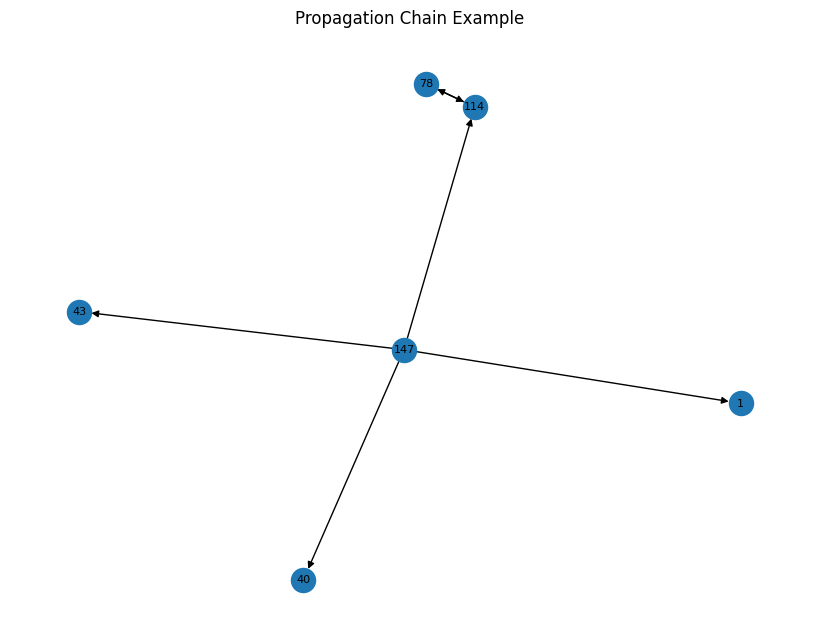

In [21]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

edge_index = graph_data_list[0]['edge_index']  # 注意是['edge_index']

# 转成NetworkX有向图
G = nx.DiGraph()
src_nodes = edge_index[0].tolist()
tgt_nodes = edge_index[1].tolist()
edges = list(zip(src_nodes, tgt_nodes))
G.add_edges_from(edges)

# 打印基本信息
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is DAG (Directed Acyclic Graph)? {nx.is_directed_acyclic_graph(G)}")

# 画出来
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=8, arrows=True)
plt.title("Propagation Chain Example")
plt.show()

我们发现有自环情况

In [3]:
num_self_loop_graphs = 0
total_self_loops = 0

for g in graph_data_list:
    edge_index = g['edge_index']
    parents = edge_index[0].tolist()
    children = edge_index[1].tolist()

    self_loops = sum([1 for p, c in zip(parents, children) if p == c])
    if self_loops > 0:
        num_self_loop_graphs += 1
        total_self_loops += self_loops

print(f"Number of graphs with self-loops: {num_self_loop_graphs}")
print(f"Total number of self-loops across all graphs: {total_self_loops}")

Number of graphs with self-loops: 1490
Total number of self-loops across all graphs: 541749


In [28]:
import torch
import json
import os

# Load features and labels
node_features_list = torch.load("../processed/twitter15_node_features.pt")
label_ids = torch.load("../processed/twitter15_labels.pt", weights_only=False)

# Load propagation chains
CHAIN_PATH = '../data/twitter15/twitter15/twitter15_chain.jsonl'
all_events = []
with open(CHAIN_PATH, 'r') as f:
    for line in f:
        all_events.append(json.loads(line))

print(f"Loaded {len(all_events)} events.")

# Build edge_index
def build_edge_index(chain):
    node_id_map = {node['tweet_id']: idx for idx, node in enumerate(chain)}
    edges = []
    for node in chain:
        child_idx = node_id_map[node['tweet_id']]
        if node['parent'] != 'ROOT':
            parent_idx = node_id_map.get(node['parent'], None)
            if parent_idx is not None:
                edges.append((parent_idx, child_idx))
    if len(edges) == 0:
        edges.append((0, 0))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# Function to remove self-loops
def remove_self_loops(edge_index):
    mask = edge_index[0] != edge_index[1]
    return edge_index[:, mask]

# Assemble graphs (with self-loop removal)
graph_data_list = []

for i, event in enumerate(all_events):
    node_features = node_features_list[i]
    label = label_ids[i]
    edge_index = build_edge_index(event['chain'])
    id_list = [node['tweet_id'] for node in event['chain']]

    # Remove self-loops
    edge_index = remove_self_loops(edge_index)

    graph = {
        'x': node_features,
        'edge_index': edge_index,
        'y': label,
        'idx2id': id_list
    }
    graph_data_list.append(graph)

# Save into a single .pt file
CLEAN_SAVE_PATH = "../processed/twitter15_graph_data_clean.pt"
torch.save(graph_data_list, CLEAN_SAVE_PATH)

print(f"Successfully saved cleaned graph data to {CLEAN_SAVE_PATH}")

Loaded 1490 events.
Successfully saved cleaned graph data to ../processed/twitter15_graph_data_clean.pt


In [29]:
import torch

# 加载已经保存好的文件
graph_data_list = torch.load("../processed/twitter15_graph_data_clean.pt", weights_only=False)

# 打印前3条链的 edge_index 和 idx2id
for i in range(2):
    print(f"--- Graph {i} ---")
    graph = graph_data_list[i]
    edge_index = graph['edge_index']
    idx2id = graph['idx2id']
    
    print(f"Edge Index:\n{edge_index}")
    print(f"idx2id:\n{idx2id}")
    
    # 检查最大节点编号
    print(f"Max node index: {edge_index.max().item() if edge_index.numel() > 0 else 'No edges'}")
    print(f"Number of nodes: {len(idx2id)}")
    print(f"Expected node indices: 0 to {len(idx2id)-1}")
    print("\n")

--- Graph 0 ---
Edge Index:
tensor([[147, 147, 147, 147, 147, 114,  78],
        [  1,  40,  40,  43, 114,  78, 114]])
idx2id:
['731166399389962242', '731168205788471297', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731166399389962242', '731177762367655938', '7311663993899

In [30]:
import torch
import networkx as nx

# 加载刚才保存的clean graph数据
graph_data_list_clean = torch.load("../processed/twitter15_graph_data_clean.pt", weights_only=False)

# 统计自环信息
total_graphs = len(graph_data_list_clean)
num_graphs_with_self_loops = 0
total_self_loops = 0

for g in graph_data_list_clean:
    edge_index = g['edge_index']
    parents = edge_index[0].tolist()
    children = edge_index[1].tolist()

    self_loops = sum([1 for p, c in zip(parents, children) if p == c])
    if self_loops > 0:
        num_graphs_with_self_loops += 1
        total_self_loops += self_loops

print("====== Validation Result ======")
print(f"Total graphs checked: {total_graphs}")
print(f"Graphs with self-loops: {num_graphs_with_self_loops}")
print(f"Total number of self-loops: {total_self_loops}")
print("================================")

====== Validation Result ======
Total graphs checked: 1490
Graphs with self-loops: 0
Total number of self-loops: 0
